# Calculating the resistivity of the grain boundary.

Once the Poisson-Boltzmann solver has converged, the potential, charge density and defect distributions have reached their equilibrium values. Using these equilibrium values the resistivity and activation energy can be calculated.

Taking the resistivity ($\rho$) as 
$$ \rho = \frac{1}{\sigma} = \frac{1}{ c \mu z }$$

Where $\sigma$ is the conductivity, $c$ is the concentration, $\mu$ is the mobility and $z$ is the valence. Treating each site as a resistor in series, the grain boundary resistivity can be calculated by taking the ratio of the sum of the resistivity at all sites to the resistivity in the bulk.

$$ r_{GB} = \frac{\rho_{i,x}}{\rho_{i, \infty }} = \frac{ c_{i, \infty} \mu_i x_i }{\sum_x c_{i,x} \mu_i z_i } $$

Assuming constant mobility for the mobile defect across the space charge regions, the grain boundary resistivity becomes:

$$ r_{GB} = \frac{c_{i,\infty}}{\sum_x c_{i,x} } $$

The resistivity ratio calculation in the code is only suitable when the Poisson-Boltzmann solver is used under the Mott-Schottky approximation as this method assumes that there is only one mobile defect. Once the resisitivity ratio has been calculated, it can be extended into an activation energy from the Arrhenius relationship.

$$ E_a = \frac{\mathrm{d ln}r_{GB}}{\mathrm{d}\left( \frac{1}{k_BT} \right) } $$

Below, the resistivity ratio has been calculated for the system where defects are specific to their sites, there is a site with two positively charged defects, followed by two sites which each have one negatively charged defect. The central positively charged defects have a segregation energy of -1.0 eV and the negatively charged defects are fixed to their bulk mole fractions under the Mott-Schottky approximation. The figure below shows the grain boundary resistivity for the system at a range of temperatures between 773.15 K and 1273.15 K. The resistivity decreases as temperature increases as expected.  

In [1]:
import os
os.getcwd()

import sys
sys.path.append('/Users/glw33/source/project')

from project.defect_species import Defect_Species
from project.set_of_sites import Set_of_Sites
from project.calculation import Calculation
from project.constants import boltzmann_eV
from project.onedefect_onedopant_calculations import *
from project.general_calculations import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

In [2]:
alpha = 0.0005

conv = 1e-8
grid_x_min = -2.5e-8
grid_x_max = +2.5e-8

limits = [grid_x_min-5e-10, grid_x_max+5e-10]

index = 111

valence = [ +1.0, -1.0 ]
site_labels = ['site_1', 'site_2']
defect_labels = ['defect_1', 'defect_2']

dielectric = 50
b = 1e-9
c = 1e-9

temp = [ 773.15, 873.15, 973.15, 1073.15, 1173.15, 1273.15 ]
mole_fractions = [[0.2,0.2],[0.2,0.2],[0.2,0.2],[0.2,0.2],[0.2,0.2],[0.2,0.2]]

desired_mobile_defect_mf = 0.2
percentage_dopant = 20

data_2 = '/Users/glw33/source/project/userguides/input_data/example_data_4_alternate_sites_one_defect.txt' 

resistivity_ratio_list = []

boundary_conditions = 'periodic'

for t, m in zip( temp, mole_fractions ):
    defect_species = { l : Defect_Species( l, v, m ) for l, v, m in zip( defect_labels, valence, m) }
    
    all_sites = Set_of_Sites.set_of_sites_from_input_data( data_2, limits, defect_species )
    for site in all_sites.subset( 'site_2' ):
        site.defect_with_label('defect_2').fixed = True
        
    grid = Grid.grid_from_set_of_sites( all_sites, limits[0], limits[1], b, c )
    
    calculation_object = Calculation( grid, alpha, conv, t, boundary_conditions )
    
    calculation_object.solve()
    calculation_object.form_subgrids( site_labels )
    calculation_object.calculate_resistivity_ratio( desired_mobile_defect_mf )
    calculation_object.mole_fractions
    
    resistivity_ratio_list.append( calculation_object.resistivity_ratio )

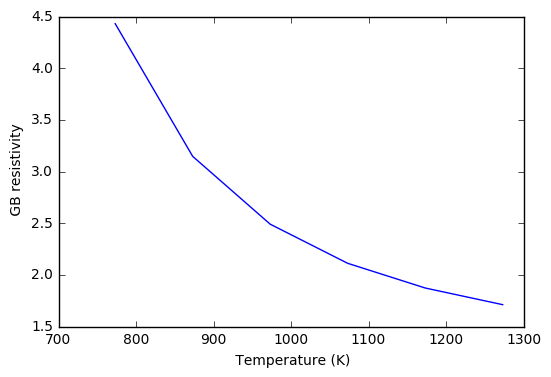

In [3]:
plt.plot( temp, resistivity_ratio_list)
plt.xlabel( ' Temperature (K)' )
plt.ylabel( ' GB resistivity' )
plt.show()

The activation energy can then be calculated from the Arrhenius relationship as described above using the ```calculate_activation_energy``` function in the source code. The function takes the resistivity ratio and temperature as input, calculates $x$ as $\frac{1}{T}$ and $y$ as $ \mathrm{ln} \left( \frac{1}{r_{GB}}\right) $. The slope at each point is calculated using a central difference method and the activation energy is calculated as the slope * Boltzmann constant. 

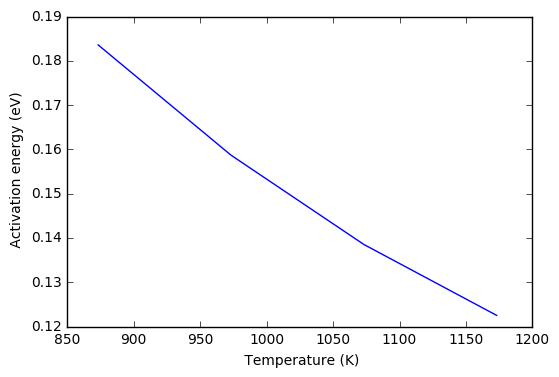

In [4]:
Ea = calculate_activation_energy( resistivity_ratio_list, temp ) 
plt.plot( temp[1:-1], Ea )
plt.xlabel( ' Temperature (K)' )
plt.ylabel( ' Activation energy (eV)' )